In [1]:
from scipy.integrate import odeint
import math 
import numpy as np
import matplotlib.pyplot as plt
import theano
%matplotlib inline
THEANO_FLAGS='optimizer=fast_compile'

theano.config.exception_verbosity= 'high'

In this example we will showcase the usage of PyMC3 for model selection. For this purpose we have chosen the Goodwin oscillator model that describes circadian rythms. The model is described as:
\begin{align}
\frac{dX_1}{dt}&=\frac{a_1}{1+a_2 X^\rho_g} - \alpha X_1\\
\frac{dX_2}{dt}&=k_1 X_1 - \alpha X_2\\
& \ \vdots \\
\frac{dX_g}{dt}&=k_{g-1} X_{g-1} - \alpha X_{g},
\end{align}

where $a_1, a_2, \alpha, k_1, \ldots, k_{g-1}$ are tunable parameters and we set $\rho>8$ for sustained oscillations. Hence, a model with $g$ species has $g+2$ model parameters that we want to infer. We set this up as a model selection problem thus we want to estimate the Bayes factor between two models: 1) where $g=3$ and 2) $g=5$.

In [2]:
def model_deriv_GDW3(y, t, param):
    #Define parameters
    a1, a2, alpha, k1, k2=param
    
    #define states
    X1, X2, X3=y
    #define derivatives
    dX1_dt=a1/(1+a2*(X3**10)) -alpha*X1
    dX2_dt=k1*X1 - alpha*X2
    dX3_dt=k2*X2 - alpha*X3
    
    
    return dX1_dt,dX2_dt,dX3_dt
def model_deriv_GDW5(y, t, param):
    #Define parameters
    a1, a2, alpha, k1, k2, k3, k4=param
    
    #define states
    X1, X2, X3, X4, X5=y
    #define derivatives
    dX1_dt=a1/(1+a2*(X5**10)) -alpha*X1
    dX2_dt=k1*X1 - alpha*X2
    dX3_dt=k2*X2 - alpha*X3
    dX4_dt=k3*X3 - alpha*X4
    dX5_dt=k4*X4 - alpha*X5
    
    return dX1_dt,dX2_dt,dX3_dt,dX4_dt,dX5_dt  
def model_sol_GDW3(param):
    
    y0 = [0,0,0]
    time = np.linspace(0, 50, 120)
    solution = odeint(model_deriv_GDW3, y0, time, args=(param,))
    return np.array(solution)
def model_sol_GDW5(param):
    
    y0 = [0,0,0,0,0]
    time = np.linspace(0, 50, 120)
    solution = odeint(model_deriv_GDW5, y0, time, args=(param,))
    return np.array(solution[:,0:3])

We generate synthetic data from the $3$ species model and fit both the $3$ and $5$ species model to this data. We estimate the marginal likelihood in each case using the SMC sampler and then finally calculate the Bayes Factor


In [3]:
sigma=0.2
solGD3=model_sol_GDW3([1.97,0.15,0.53,0.46,1.49])#,1.69,1.69
Y=solGD3+np.random.randn(120,3)*sigma

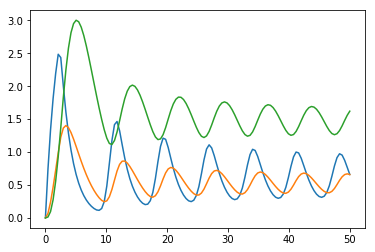

In [4]:
time = np.linspace(0, 50, 120)

plt.plot(time,solGD3)

We will define individual as_ops for each model. Note that in this case our input type is one single vector. The reason for this will be apparent when we define the priors in PyMC3

In [5]:
import theano.tensor as tt
from theano.compile.ops import as_op

@as_op(itypes=[tt.dvector], otypes=[tt.dmatrix])
def GDW3_ode_sol(param):
    
    sol=model_sol_GDW3(param)
    
    return sol
@as_op(itypes=[tt.dvector], otypes=[tt.dmatrix])
def GDW5_ode_sol(param):
    

    sol=model_sol_GDW5(param)
    
    return sol

We put a $\mathcal{\Gamma}(2,1)$ prior on all parameters. We also define seperate pymc models for the $3$ and $5$ species variants. This is for simplicity and the code can be made much more compact.

In [6]:
import pymc3 as pm
from pymc3.step_methods import smc
from tempfile import mkdtemp
from scipy import optimize
GDW3_model = pm.Model()
n_steps = 20
n_chains = 1000

with GDW3_model:

    # Priors for unknown model parameters. NB we defined a single prior for all parameters. 
    #This is the reason we had tt.dvector and not [tt.dscalar,...,tt.dscalar] in the as_ops.
    
    paramG3 = pm.Gamma('paramG3', alpha=2,beta=1, transform=None, shape=5)
    
    
    mu = GDW3_ode_sol(paramG3)
    cov=np.eye(3)*sigma**2
    
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.MvNormal('Y_obs', mu=mu, cov=cov, observed=Y)

    test_folder = mkdtemp(prefix='SMC_TEST')
    trace3 = smc.sample_smc(samples=5000,n_chains=n_chains,progressbar=True,
                        homepath=test_folder,stage=0,cores=10,threshold=1,random_seed=20)

/home/sanosh/pymc3/pymc3/step_methods/smc.py:491: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
/home/sanosh/pymc3/pymc3/step_methods/smc.py:118: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
/usr/local/lib/python2.7/dist-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f81a11c0990>,
      dtype=object)

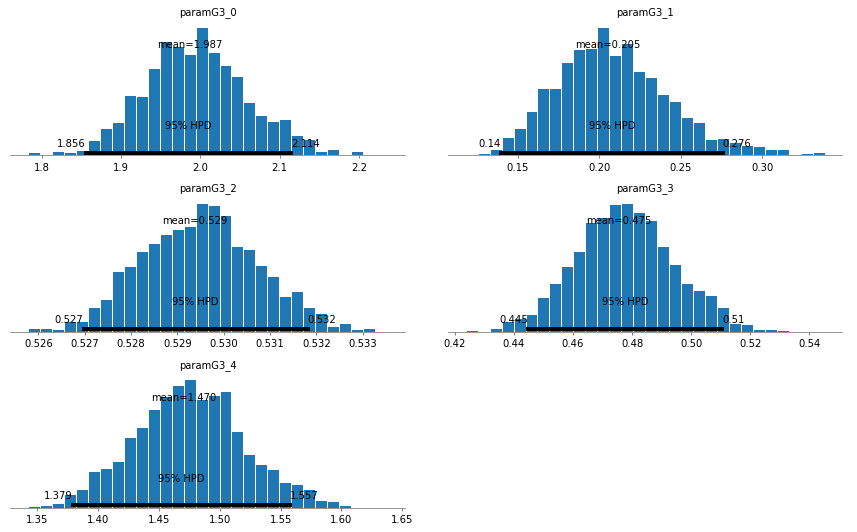

In [7]:
pm.plot_posterior(trace3)

In [8]:
GDW5_model = pm.Model()
n_steps = 20
n_chains = 1000

with GDW5_model:

    # Priors for unknown model parameters
    
    paramG5 = pm.Gamma('paramG5', alpha=2,beta=1, transform=None, shape=7)
    
    
    Y_obs = pm.MvNormal('Y_obs', mu=mu, cov=cov, observed=Y)
    
    mu = GDW5_ode_sol(paramG5)
    cov=np.eye(3)*sigma**2
    # Likelihood (sampling distribution) of observations
    test_folder = mkdtemp(prefix='SMC_TEST')
    trace5 = smc.sample_smc(samples=5000,n_chains=n_chains,progressbar=True,
                        homepath=test_folder,stage=0,cores=10,threshold=1,random_seed=20)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8189170110>,
      dtype=object)

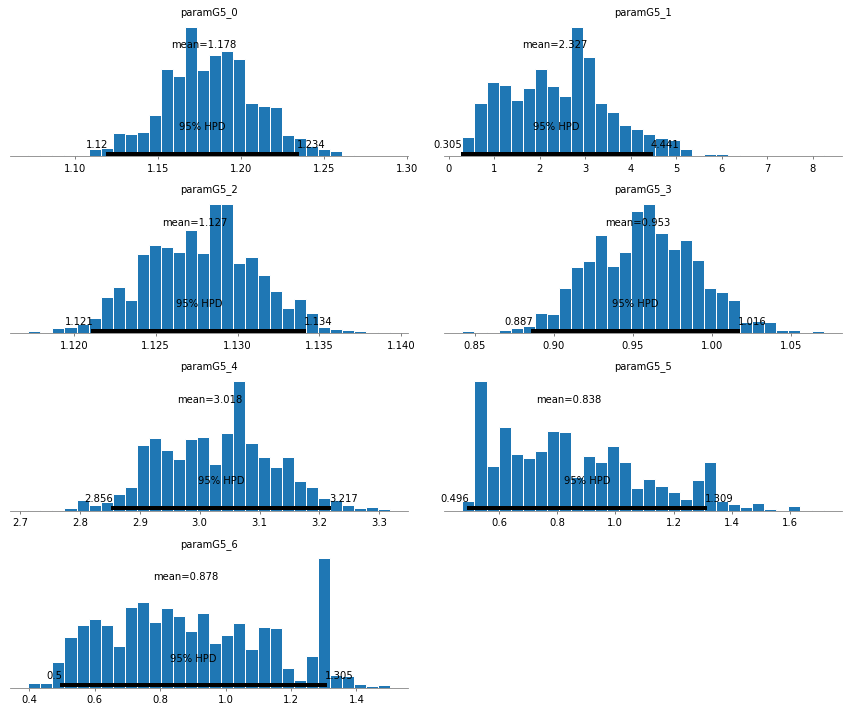

In [9]:
pm.plot_posterior(trace5)

We can now compute the Bayes factor between Model $3$ and Model $5$ as: $BF_{3_5}=p(Y|GW3)/p(Y|GW5)$

In [15]:
GDW3_model.marginal_likelihood/GDW5_model.marginal_likelihood

1.101853458853304